# 基于PaddleSeg的遥感地块分割

## 一、项目背景介绍
遥感影像地块分割, 旨在对遥感影像进行像素级内容解析，对遥感影像中感兴趣的类别进行提取和分类，在城乡规划、防汛救灾等领域具有很高的实用价值，在工业界也受到了广泛关注。现有的遥感影像地块分割数据处理方法局限于特定的场景和特定的数据来源，且精度无法满足需求。因此在实际应用中，仍然大量依赖于人工处理，需要消耗大量的人力、物力、财力。本项目旨在衡量遥感影像地块分割模型在多个类别（如建筑、道路、林地等）上的效果，利用人工智能技术，对多来源、多场景的异构遥感影像数据进行充分挖掘，打造高效、实用的算法，提高遥感影像的分析提取能力。

## 二、数据介绍
### [遥感地块分割数据集](https://aistudio.baidu.com/aistudio/datasetdetail/77571)
### 训练数据集
样例图片及其标注如下图所示：

![](https://ai.bdstatic.com/file/A3366220FE9B4C768585E9599903F8B2)
![](https://ai.bdstatic.com/file/4D1CE900299E4193A374EA62515C626B) 

训练数据集文件名称：train_and_label.zip
包含2个子文件，分别为：训练数据集（原始图片）文件、训练数据集（标注图片）文件，详细介绍如下：

- 训练数据集（原始图片）
	- 文件名称：img_train
	- 包含66,653张分辨率为2m/pixel，尺寸为256 * 256的JPG图片，每张图片的名称形如T000123.jpg。

- 训练数据集（标注图片）
	- 文件名称：lab_train
	- 包含66,653张分辨率为2m/pixel，尺寸为256 * 256的PNG图片，每张图片的名称形如T000123.png。
> 备注： 全部PNG图片共包括4种分类，像素值分别为0、1、2、3。此外，像素值255为未标注区域，表示对应区域的所属类别并不确定，在评测中也不会考虑这部分区域。

### 测试数据集
测试数据集文件名称：img_test.zip，详细介绍如下：
包含4,609张分辨率为2m/pixel，尺寸为256 * 256的JPG图片，文件名称形如123.jpg。

## 三、模型介绍
> References: [HardNet飞桨（Paddle）论文复现(By:Jordan2020)](https://aistudio.baidu.com/aistudio/projectdetail/1848242)

**HarDNet**指的是Harmonic DenseNet: A low memory traffic network，其突出的特点就是低内存占用率。过去几年，随着更强的计算能力和更大的数据集，我们能够训练更加复杂的网络。对于实时应用，我们面临的问题是如何在提高计算效率的同时，降低功耗。在这种情况下，作者们提出了HarDNet在两者之间寻求最佳平衡。

HarDNet可以用于图像分割、目标检测和语义分割，其架构是基于Densely Connected Network。在HarDNet中，作者提出了Harmonic Dense Bocks的概念。如下图所示，可以看到该网络就像多个谐波。HarDNet的全称就是Harmonic Densely Connected Network。  
![](https://ai-studio-static-online.cdn.bcebos.com/e3faeaed2ba74b1f867b673607332114935ec29f37d6468b99f5a7a6682df1a8)  
作者对每一层的MoC施加一个软约束，以设计一个低CIO网络模型，并合理增加MACs。如下图所示，避免使用MoC非常低的层，例如具有非常大输入/输出通道比的Conv1x1层。受Densely Connected Networks的启发，作者提出了Harmonic Densely Connected Network (HarD- Net) 。首先减少来自DenseNet的大部分层连接，以降低级联损耗。然后，通过增加层的通道宽度来平衡输入/输出通道比率。  
![](https://ai-studio-static-online.cdn.bcebos.com/ef3d058b1e0c42b583d479366eb2011252a8a0af79d041e7b63ca80c6d6d1c04)

## 四、环境安装与数据准备

### 1. PaddleSeg安装及环境配置

In [ ]:
# 安装paddleseg
!pip install paddleseg

### 2. 解压数据集

In [2]:
!unzip -q data/data77571/train_and_label.zip -d data/data77571
!unzip -q data/data77571/img_test.zip -d data/data77571

!tree data/data77571 -d

data/data77571
├── img_testA
├── img_train
├── lab_train
└── __MACOSX
    └── img_testA

5 directories


### 3. EISeg标注数据演示
> [EISeg官方文档](https://github.com/PaddlePaddle/PaddleSeg/tree/release/2.2/contrib/EISeg)

EISeg(Efficient Interactive Segmentation)是基于飞桨开发的一个高效智能的交互式分割标注软件。涵盖了高精度和轻量级等不同方向的高质量交互式分割模型，方便开发者快速实现语义及实例标签的标注，降低标注成本。 另外，将EISeg获取到的标注应用到PaddleSeg提供的其他分割模型进行训练，便可得到定制化场景的高精度模型，打通分割任务从数据标注到模型训练及预测的全流程。

#### **模型准备**
在使用EIseg前，请先下载模型参数。EISeg开放了在COCO+LVIS和大规模人像数据上训练的四个标注模型，满足通用场景和人像场景的标注需求。其中模型结构对应EISeg交互工具中的网络选择模块，用户需要根据自己的场景需求选择不同的网络结构和加载参数。  
本项目选用的是
| 模型类型 | 适用场景 | 模型结构 | 下载地址|
| --- | --- | --- | ---|
| **高精度模型**  | **适用于通用场景的图像标注。** | **HRNet18_OCR64** | **[hrnet18_ocr64_cocolvis](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18_ocr64_cocolvis.pdparams)** |
| 轻量化模型  | 适用于通用场景的图像标注。 |HRNet18s_OCR48 | [hrnet18s_ocr48_cocolvis](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18s_ocr48_cocolvis.pdparams) |
| 高精度模型  | 适用于人像标注场景。 |HRNet18_OCR64 | [hrnet18_ocr64_human](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18_ocr64_human.pdparams) |
| 轻量化模型  | 适用于人像标注场景。 |HRNet18s_OCR48 | [hrnet18s_ocr48_human](https://bj.bcebos.com/paddleseg/dygraph/interactive_segmentation/ritm/hrnet18s_ocr48_human.pdparams) |

#### **安装使用**

EISeg提供多种安装方式，其中使用[pip](#PIP)和[运行代码](#运行代码)方式可兼容Windows，Mac OS和Linux。为了避免环境冲突，推荐在conda创建的虚拟环境中安装。

版本要求:

* PaddlePaddle >= 2.1.0

PaddlePaddle安装请参考[官网](https://www.paddlepaddle.org.cn/install/quick?docurl=/documentation/docs/zh/install/pip/windows-pip.html)。

这里使用pip安装方式：

```shell
pip install eiseg
```
pip会自动安装依赖。安装完成后命令行输入：
```shell
eiseg
```
即可运行软件。

#### **使用**

打开软件后，在对项目进行标注前，需要进行如下设置：

1. **模型参数加载**

   选择合适的网络，并加载对应的模型参数。目前在EISeg中，网络分为`HRNet18s_OCR48`和`HRNet18_OCR64`，并分别提供了人像和通用两种模型参数。在正确加载模型参数后，右下角状态栏会给予说明。若网络参数与模型参数不符，将会弹出警告，此时加载失败需重新加载。正确加载的模型参数会记录在`近期模型参数`中，可以方便切换，并且下次打开软件时自动加载退出时的模型参数。

2. **图像加载**

   打开图像/图像文件夹。当看到主界面图像正确加载，`数据列表`正确出现图像路径即可。

3. **标签添加/加载**

   添加/加载标签。可以通过`添加标签`新建标签，标签分为4列，分别对应像素值、说明、颜色和删除。新建好的标签可以通过`保存标签列表`保存为txt文件，其他合作者可以通过`加载标签列表`将标签导入。通过加载方式导入的标签，重启软件后会自动加载。

4. **自动保存设置**

   在使用中可以将`自动保存`设置上，设定好文件夹即可，这样在使用时切换图像会自动将完成标注的图像进行保存。

当设置完成后即可开始进行标注，默认情况下常用的按键/快捷键如下，如需修改可按`E`弹出快捷键修改。

### 4. 构造数据集

total: 66652
data/data77571/img_train/T130539.jpg
data/data77571/lab_train/T130539.png
('data/data77571/img_train/T042700.jpg', 'data/data77571/lab_train/T042700.png')


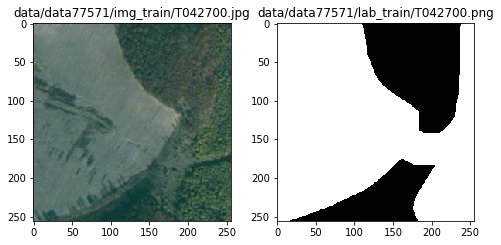

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random

datas = []
image_base = 'data/data77571/img_train'   # 训练集原图路径
annos_base = 'data/data77571/lab_train'   # 训练集标签路径

# 读取原图文件名
ids_ = [v.split('.')[0] for v in os.listdir(image_base)]

# 将训练集的图像集和标签路径写入datas中
for id_ in ids_:
    img_pt0 = os.path.join(image_base, '{}.jpg'.format(id_))
    img_pt1 = os.path.join(annos_base, '{}.png'.format(id_))
    datas.append((img_pt0.replace('/home/aistudio', ''), img_pt1.replace('/home/aistudio', '')))
    if os.path.exists(img_pt0) and os.path.exists(img_pt1):
        pass
    else:
        raise "path invalid!"

random.shuffle(datas)

# 打印datas的长度和具体存储例子
print('total:', len(datas))
print(datas[0][0])
print(datas[0][1])
print(datas[10][:])

plt.figure(figsize=(8, 8))
for i in range(len(datas[10][:])):
    plt.subplot(len(datas[10][:]), 2, i + 1)
    plt.title(datas[10][i])
    plt.imshow(cv2.imread(datas[10][i])[:, :, ::-1])
    
plt.show()

#### **将训练集的图像集和标签路径写入datas中**

In [ ]:
import numpy as np
import os

datas = []
image_base = 'data/data77571/img_train'   # 训练集原图路径
annos_base = 'data/data77571/lab_train'   # 训练集标签路径

# 读取原图文件名
ids_ = [v.split('.')[0] for v in os.listdir(image_base)]

# 将训练集的图像集和标签路径写入datas中
for id_ in ids_:
    img_pt0 = os.path.join(image_base, '{}.jpg'.format(id_))
    img_pt1 = os.path.join(annos_base, '{}.png'.format(id_))
    datas.append((img_pt0.replace('/home/aistudio', ''), img_pt1.replace('/home/aistudio', '')))
    if os.path.exists(img_pt0) and os.path.exists(img_pt1):
        pass
    else:
        raise "path invalid!"

# 打印datas的长度和具体存储例子
print('total:', len(datas))
print(datas[0][0])
print(datas[0][1])
print(datas[10][:])

total: 66652
data/data77571/img_train/T127206.jpg
data/data77571/lab_train/T127206.png
('data/data77571/img_train/T047668.jpg', 'data/data77571/lab_train/T047668.png')


#### **将训练集、测试集图片路径写入txt文件**

In [ ]:
import numpy as np

# 四类标签，这里用处不大，比赛评测是以0、1、2、3类来对比评测的
labels = ['建筑', '耕地', '林地',  '其他']

# 将labels写入标签文件
with open('data/labels.txt', 'w') as f:
    for v in labels:
        f.write(v + '\n')

# 随机打乱datas
np.random.seed(5)
np.random.shuffle(datas)

# 验证集与训练集的划分，0.05表示5%为训练集，95%为训练集
split_num = int(0.05*len(datas))

# 划分训练集和验证集
train_data = datas[:-split_num]
val_data = datas[-split_num:]

# 写入训练集list
with open('data/train_list.txt', 'w') as f:
    for img, lbl in train_data:
        f.write(img + ' ' + lbl + '\n')

# 写入验证集list
with open('data/val_list.txt', 'w') as f:
    for img, lbl in val_data:
        f.write(img + ' ' + lbl + '\n')

# 打印训练集和测试集大小
print('train:', len(train_data))
print('val:', len(val_data))

train: 63320
val: 3332


#### **构建训练集和验证集**

In [ ]:
import paddleseg.transforms as T
from paddleseg.datasets import Dataset

dataset_root = './'
train_path = 'data/train_list.txt'
val_path = 'data/val_list.txt'
num_classes = 4

# 定义训练和验证时的transforms
train_transforms = [
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomDistort(
        brightness_range=0.2, brightness_prob=0.5,
        contrast_range=0.2, contrast_prob=0.5,
        saturation_range=0.2, saturation_prob=0.5,
        hue_range=15, hue_prob=0.5),
    T.RandomPaddingCrop(crop_size=(256, 256)),
    T.Resize(target_size=(256, 256)),
    T.Normalize()
]
eval_transforms = [
    T.Resize((256, 256)),
    T.Normalize()
]

# 构建训练集
train_dataset = Dataset(transforms = train_transforms,
                  dataset_root = dataset_root,
                  num_classes = num_classes,
                  train_path = train_path,
                  mode = 'train')

# 构建验证集
eval_dataset = Dataset(transforms = eval_transforms,
                  dataset_root = dataset_root,
                  num_classes = num_classes,
                  val_path = val_path,
                  mode = 'val')

## 五、模型训练

### 1. 模型准备

#### **构建模型**

In [ ]:
from paddleseg.models import HarDNet
model = HarDNet(num_classes=4)

#### **构建优化器**

In [77]:
import paddle
# 设置学习率
base_lr = 0.01
lr = paddle.optimizer.lr.PolynomialDecay(base_lr, power=0.9, decay_steps=1000, end_lr=0)

optimizer = paddle.optimizer.Momentum(lr, parameters=model.parameters(), momentum=0.9, weight_decay=4.0e-5)

#### **构建损失函数**

In [78]:
from paddleseg.models.losses import CrossEntropyLoss
losses = {}
losses['types'] = [CrossEntropyLoss()]
losses['coef'] = [1]

### 2. 模型训练

In [79]:
# 模型训练
from paddleseg.core import train
train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=eval_dataset,
    optimizer=optimizer,
    save_dir='output',
    iters=1000,
    batch_size=64,
    save_interval=200,
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True)


```
2022-02-26 00:27:05 [INFO]	[EVAL] #Images: 3332 mIoU: 0.4254 Acc: 0.6363 Kappa: 0.4842 Dice: 0.5809
2022-02-26 00:27:05 [INFO]	[EVAL] Class IoU: 
[0.4181 0.6618 0.3884 0.2332]
2022-02-26 00:27:05 [INFO]	[EVAL] Class Acc: 
[0.5127 0.768  0.6399 0.599 ]
2022-02-26 00:27:05 [INFO]	[EVAL] The model with the best validation mIoU (0.4254) was saved at iter 1000.
```

## 六、模型评估

### 1. 评估

In [80]:
from paddleseg.core import evaluate
evaluate(
        model,
        eval_dataset)

```
2022-02-26 00:28:53 [INFO]	[EVAL] #Images: 3332 mIoU: 0.4254 Acc: 0.6363 Kappa: 0.4842 Dice: 0.5809
2022-02-26 00:28:53 [INFO]	[EVAL] Class IoU: 
[0.4181 0.6618 0.3884 0.2332]
2022-02-26 00:28:53 [INFO]	[EVAL] Class Acc: 
[0.5127 0.768  0.6399 0.599 ]
(0.42536737322998697,
 0.6362991929908635,
 array([0.41810411, 0.66180658, 0.38839619, 0.23316261]),
 array([0.5126595 , 0.76797334, 0.63987386, 0.59896736]),
 0.48420433715407724)
 ```

### 2. 多尺度+翻转评估

In [81]:
evaluate(
        model,
        eval_dataset,
        aug_eval=True,
        scales=[0.75, 1.0, 1.25],
        flip_horizontal=True)

```
2022-02-26 00:30:29 [INFO]	Start evaluating (total_samples: 3332, total_iters: 3332)...
3332/3332 [==============================] - 531s 159ms/step - batch_cost: 0.1581 - reader cost: 2.7121e-0
2022-02-26 00:39:20 [INFO]	[EVAL] #Images: 3332 mIoU: 0.4273 Acc: 0.6318 Kappa: 0.4814 Dice: 0.5830
2022-02-26 00:39:20 [INFO]	[EVAL] Class IoU: 
[0.4154 0.6645 0.3928 0.2366]
2022-02-26 00:39:20 [INFO]	[EVAL] Class Acc: 
[0.5002 0.8095 0.6369 0.5393]
(0.4273378027662387,
 0.6317629946253964,
 array([0.41538115, 0.66454304, 0.39282122, 0.23660579]),
 array([0.50023599, 0.80945294, 0.63694697, 0.53925723]),
 0.4813580649375135)
```
根据训练与评估结果，mIOU可以达到0.425左右。

### 3. 效果可视化

#### **构建模型**

In [82]:
from paddleseg.models import HarDNet
model = HarDNet(num_classes=4)

#### **创建transform**

In [83]:
import paddleseg.transforms as T
transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.RandomHorizontalFlip(),
    T.Normalize()
])

#### **构建待预测的图像列表**

In [84]:
import os
def get_image_list(image_path):
    """Get image list"""
    valid_suffix = [
        '.JPEG', '.jpeg', '.JPG', '.jpg', '.BMP', '.bmp', '.PNG', '.png'
    ]
    image_list = []
    image_dir = None
    if os.path.isfile(image_path):
        if os.path.splitext(image_path)[-1] in valid_suffix:
            image_list.append(image_path)
    elif os.path.isdir(image_path):
        image_dir = image_path
        for root, dirs, files in os.walk(image_path):
            for f in files:
                if os.path.splitext(f)[-1] in valid_suffix:
                    image_list.append(os.path.join(root, f))
    else:
        raise FileNotFoundError(
            '`--image_path` is not found. it should be an image file or a directory including images'
        )

    if len(image_list) == 0:
        raise RuntimeError('There are not image file in `--image_path`')

    return image_list, image_dir
image_path = 'data/data77571/img_testA' # 也可以输入一个包含图像的目录
image_list, image_dir = get_image_list('data/data77571/img_testA')

#### **预测**

In [85]:
from paddleseg.core import predict
predict(
        model,
        model_path='output/best_model/model.pdparams',
        transforms=transforms,
        image_list=image_list,
        image_dir=image_dir,
        save_dir='output/results'
    )

#### **预测效果**
伪彩色预测结果：  
![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAMAAABrrFhUAAADAFBMVEWAAAAAgACAgAAAAICAAIAA%0AgICAgIBAAADAAABAgADAgABAAIDAAIBAgIDAgIAAQACAQAAAwACAwAAAQICAQIAAwICAwIBAQADA%0AQABAwADAwABAQIDAQIBAwIDAwIAAAECAAEAAgECAgEAAAMCAAMAAgMCAgMBAAEDAAEBAgEDAgEBA%0AAMDAAMBAgMDAgMAAQECAQEAAwECAwEAAQMCAQMAAwMCAwMBAQEDAQEBAwEDAwEBAQMDAQMBAwMDA%0AwMAgAACgAAAggACggAAgAICgAIAggICggIBgAADgAABggADggABgAIDgAIBggIDggIAgQACgQAAg%0AwACgwAAgQICgQIAgwICgwIBgQADgQABgwADgwABgQIDgQIBgwIDgwIAgAECgAEAggECggEAgAMCg%0AAMAggMCggMBgAEDgAEBggEDggEBgAMDgAMBggMDggMAgQECgQEAgwECgwEAgQMCgQMAgwMCgwMBg%0AQEDgQEBgwEDgwEBgQMDgQMBgwMDgwMAAIACAIAAAoACAoAAAIICAIIAAoICAoIBAIADAIABAoADA%0AoABAIIDAIIBAoIDAoIAAYACAYAAA4ACA4AAAYICAYIAA4ICA4IBAYADAYABA4ADA4ABAYIDAYIBA%0A4IDA4IAAIECAIEAAoECAoEAAIMCAIMAAoMCAoMBAIEDAIEBAoEDAoEBAIMDAIMBAoMDAoMAAYECA%0AYEAA4ECA4EAAYMCAYMAA4MCA4MBAYEDAYEBA4EDA4EBAYMDAYMBA4MDA4MAgIACgIAAgoACgoAAg%0AIICgIIAgoICgoIBgIADgIABgoADgoABgIIDgIIBgoIDgoIAgYACgYAAg4ACg4AAgYICgYIAg4ICg%0A4IBgYADgYABg4ADg4ABgYIDgYIBg4IDg4IAgIECgIEAgoECgoEAgIMCgIMAgoMCgoMBgIEDgIEBg%0AoEDgoEBgIMDgIMBgoMDgoMAgYECgYEAg4ECg4EAgYMCgYMAg4MCg4MBgYEDgYEBg4EDg4EBgYMDg%0AYMBg4MDg4MAAACD/CiuwAAAITklEQVR4nO2d7XajOgxFWeT933mmaZLyYVs60pFsQ/TrdoKls3cJ%0AAcK6XZbseryq8VK5Ws3MFQzbjAzjNLuxBQTZajU0pHXSr+tPzyKZPoODHxZwmu6h/+H/X2UBcoif%0AlU5+A0ySADAFhV8XWWgJ1kvAAkbh4Jv42QeBlwAM3yigzaKOzDVgEsDBt+0ACQIMESz8ZgqNW30l%0ACZBaAIlV7YE6CTBmgAR4AOgCCOciIL8vv0YwWHgrjwBveo1isFIFxPAPLqC90p6VZSBRgDe6aghc%0A0QLa68xJpxHQXmYOSjSAN+HwP9DM6klo309zTpBKKG9ebBrU+dOfF+UcyR0WGwd1/uvPi/KXaCku%0AwlNq5+GFCgD4Nxp8QZFRcG1/RdQwvJxxnZ/dN0O4YUgpI3s/+2+myB9N6fiuSy9AgHYPuLkAAn40%0Av+EIu5l0BX58xGZWOD+YLVdARBYnvnEoOCI0iw+f9y1Ea0RolD4CsMvs0CROftb3kM0RsUliBTBu%0Ak0ZdAlH4VbeBnPOSroAs9MLc9lb6Gd4cvQRI26ln+GIMwe8yMLAApJ99qLwZgd92qwZqZ56aIgBE%0AF8bqN1fNgZM0w4ULwLbXzEGTCAFj+dEVmkFgFDFjoAB8heYQDyYRR4bxW9ZoVgFtjxuPxW98E+gF%0A6AZG8ZtP2cU1cldoXk9+05vAep1WGxfE77lqF5ZYIjamdeU3fXhYMjaSxvD77ly2V1hCtqKG8AOX%0A9+hqu4AIfMYtLnB9mABqS2+T1uaWoO20VnwOP7oLhAggN2T0qW9tC9vK25kfNMAXwO02nwBqM2ND%0ApA/7PIDXid6wsqlpQG0KrZGzI2DAIeA8hRjWxw+cDTAFkNoQ8Ctdi9vxZhCT+vnVbwLxfkEjSawA%0AY7t238JmuiaKEdSgfn6tgfKtvkILcQIzJkWA7jCgFiDeFCWmJAlQGahwFRpI/YkhSfwqAzWuwvp2%0Af2ZGmgCFgSrWeXmzPTUiT4B8uvr68fU/E9mtqZ3oFL8gZSYMFrDv/RawA6zW+/XClsyERAGigdO7%0AXbjX99761JyYjypAMlB6s6sMkAK351CKLGARW3rTsQ20m9d+o2gx06UawPcAatqAlsopf69JOboJ%0AyDGw1N7UlxLQMDCygOBdYPuR7hcQcD84fBd4o3P4yV+HsgW0D7ccAbSvMPINsOorYGQBGQbGFpBg%0AgJ9pMgOjCwg3QEskfSMxqgFWoMMrVzbQaDKlAUac0otEAYPtA+0GIQKGMiCujhAwkgHN2ukEIGmV%0AK697OmA2561BBHTjP83uZKAjf6wBU4RQWsX8fAO9+SMNGKZHw2oypBqwOOPXNALCLHUzAG6vF4tW%0AJwHm7Vnc9SSDC6AbiBKge0/rsb4CogyMIQDLySEvJ0kygNk6LyHBl6LIXAEC8KAc+EKUGkvpP+0G%0AEFeVNSx+Fc52Q/yZQsVQU1IOPy4A4K+GtLHEGNBzQOTNjEYSZXe+AP2WOgtWELkzT8Dzr7A9/yLl%0A+rtZ6U8TGhXYOfIErNt687sULI2BjqxBAtaaAK8DwY0ha4iAdT0a2P3oUDCHgDN/rAFXWL8Bkf9c%0A3fhLcbkCZPidgUqmVAFuA3YB9Uxx/AG7wC83xL/upvr4Cc+U+AW8fqla/P8bNwMFC2Ab8Apw8jMe%0AsKYIWJEDQCtNBwE+A28Bq0bAeWAH/o4CCgOHEOAysMCf/uUn+RIFcHcBl4A+/NxdwCPAzT+pAB6/%0ANTjTgJr/b+59BTy2j20S8IkC7AasAij8UwlYtwI4+J7UtF6gAO63qWYBxMMAcBFE5/eewFC6AQKo%0A7F5+mgHoMngoAQUHtxNwcnBDAW4D0wvwPj50AQE+Ax0FsPh9Bjp+DPIEeB4jvIgA+6Ok/QRw+RME%0AkPnDDODLLiLgeL/mfgIesQLo/FEGggQE8PMFWBT0FDCEAaWAEP6JBMTwD2GgK3+EAPSz4HoCwDOi%0A/OfiovnBk+LPAyI/VYIP5A8SgF0aLq9Hw8sGnv82nQBoH9gLWI70sWVgWz/f0GgEKCYcM2XyGww8%0Ak1ENnEPl4eMCVqUA4E2QA1otC79GgP7auCu+LuIBX8WvPx/qS/+qCAHac+LO6K+KEPBkm0WAygAs%0AQFW9yd8lUf8Vl38YAUUDhVPzy+4BJQEZ/H0F7MbfT8BhfAcBPcnPEZQCLoXfU0Av/KUeI1NAL/oz%0AZevFsGNAJ/YCovC0X4yBfOoiXD2NJMCnIJ25jNZMFGkgH7oIJkQKNJAOXebqZiCduUwlpppUgDDA%0AJIBrIIp8k1p6vauAMPRtaOl1XbIJBYhDoGibl0Z/B6inYNkEAQPzGwWUl9UMmPhDBOjHGOMVDNjo%0AYwQAU6z5HkcFZv7hBTTeBY95+IMEML4VGV9Ace37tRvsACoDI/GTjwCiAd3jMYkCAvjbAjwVwJ8m%0AgGEggp93Eii1GJRffxVwDwHqDeGoo/Iv6gG+sMPyb6Jpt7uagHc41UbmuCPzP/PJW1xbgFzewF8B%0AN+NnG+jB7IxPaDGQAErmuwlgGuiAzIhOajOvAN6BsAczJTqpzbwCWAZ6IFOCkw4DHYCPRRMwqwEa%0AP+0TJbeM/MTbo8nAjMj12NMJMPPzdoFkYndeuoFkZG9cMflUAlz8JAO5xL6sdAO5tK6oCME8/FG3%0A9KfhD/tadxL8uG/2Z+HnCDAZSEctF0eA4bowH7VcYQLAB4+7FUkAvAvkk1aKJQA0kA9aq0ABrd7p%0AnLWi8WMG0jlrReT/CkD6Z3PWKpq/NiAZs17B+LUBqYzNuruAL/+9BRD5IQOpkI2i8n+w9oSIq+Qi%0A47+wjoxNAX1lxAhYdj8MLYCtYN+2MaQHaqVC+J99a0OsSf8BBsOaeXpfL+gAAAAASUVORK5CYII=)  
叠加效果：  
![](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYF%0ABgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoK%0ACgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAEAAQADASIA%0AAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQA%0AAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3%0AODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWm%0Ap6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEA%0AAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSEx%0ABhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElK%0AU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3%0AuLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD839Qe%0Aw06xSc3TBmXMgP8ACfy+tc/ZxX/jHVBBagrbrJh2fvSXEt74ovPsVkP3Sf6x67XwjpdlpmbWGMbo%0AgN4Pqen+fpX6visRHJstnWqScuW713d3otPNpeh8lg8LLNswhSpxUeay02Vlq/uTZPpvhw2NlHbS%0ABFTrsQ8n/D+dOuNK0mFPLFt8x/2z/jVy/v44N3l/erOe7lf/AFpr8jxfEOb42t7T2rgu0W4r8Hr6%0As/VMNkeV4SjyezU/OSTf4rT0RFd6dprtzbf+Pn/Gqc+i2JUurNHhf73A9zmrkj8ZH/A6YVdlKqoO%0AeCCODWNHO83pVFL6xP8A8Cb/AAd0VVyfK6kHH2EP/AUvxVmYbpDDcmCac+WsmHdEyQM8kAkZPtn8%0Ae9RyiMSsIMsgY7GdQpI7EjJwfbJqKYNERE+MqxBx6ik+0eX/APZ1+3UbulF83Note/n8z8dqq1aW%0AltXp28u+g7y+PLxU8cW+nWtqZKku76y0i280n/gdbcwcvtCLUJ/7KsvNjj3y/wDLOs+00WWdG1HU%0AZJv+mkFXLTSbnVQus6rK8Vqnzxwf3607GT+0naOO3byv+mlZVavJAvlKmmS6msW0ReXAZMCMDrXS%0AaU80cTyy2ZgWYfKmeT9fT6VpRS6Vp2krFZJunZPnYxc+uPasfXfEFhoUQe7fLMPlQf1r8szPifMc%0A2xEsFlkHdtrmXxO27X8q83rbXQ++wGQYPLqEcZmElpZ8r2V9k+78tr6alyWZWTawAA4cDtXD+JPE%0AQuLp4tJtc8nM2fv++O1SX/ijV/ECubKH7Pb+pPUe5703QdGuLm5WEhnDHjJ4d69vhjhqpkjnjMdO%0A0rbJuyXVy6P8Ut97NeXnmcwzjlwuFhdX6pXb6cvVfm9tr3g8NeGb7Vb9J7tXkK+v3Ix716HZeH7D%0ATrBGkIV2HzsO/wDnNSWenx6JEkUsWWIw0ad/8Kinkknn+0SSfWvmuJeJJ5vJ0MM2qK+Tk11fl2Xz%0Aeu31GQ5FRyqKrVrOr96in28+7+S03imnw7xW5+WoA8adRTrjyt/H3aj8wCOvlYQPcn75DJbbxxQ2%0ArGxt43aR/NSbMUg/gHqak8wxxtWD4mv1trZEecIwYEr6j/8AXXvcOyxEc7pey6uz3+Hre3lr2vY8%0ATPY0FlFX2vRaevT8TuLtLfxdp39o23+vSP8Afx/3/wDbrhBZxWWscjAkchCT0P8Anj8aTw/48/sL%0AVoLyKR9r/JIn99K67xj4csNQsk1vw+haG4OQR/BX6/mGG+s4OpQvbmTV/X+vuPzfC1fZ14VrX5Wn%0Ab0ZgVJUNo0jEQyt+9h4fp19akc5ANfhGKw1bCYiVGqrSi7M/VcNVpV6EatN3jJXQ6lL/ACcelGSh%0A6imSfx1gbC/x/hRwgo+f2paDMK3vC3hzRfEmm3MV/wCYZY3CnYxGxCOo4xz8w79O1c+hOzNX9B1+%0A98PtM1qiP5qAbX6Ag8HjnpkYyOvtXVgsRSo4mM6i0X9L8TweJsHmWOyepSy+bjVvFrW20ldN9rX0%0A67PS6FtfCun+FLJY7YBwVwXkXGHqXSmhVGcylnlUFsjgEZ4qfUNcudYtmtZz1wYxnrjtWeqJZ2Q1%0AAxukvnnerDGeBzX1WKzfF5pwy/bVffjOzWnvR3V0kuu1tNNfLTDZdQy3Pl7Cl7jhdPV8r2dm2+m9%0A9ddPNJ55JHfzKasnmd6nvoEkT7RbfOj1V8zfxivi9T6ofwgqNmVVLMQABkk9qfvHoaydV1Z7gGxt%0AU4Jwzg9fb6V6eU5Vic3xSpUlp9p9Eu/+S6nnZnmWHyzDOrUevRdW/wCt30KF1J58zzb8bmLY9Mmq%0A2paTLd2WTJtb/bkpbvU7O0/0e2j+0z/c2R0+40PUfsy6trFxvH/LOGv3iEY0IKMdlofjU1Kc3KW7%0AG6b/AMJLaWP2eS337/8AVvWjYeHra3n/ALR168+0OP8AVp/AlGhWGq67MkckuyL/ANAp2pW9tpVz%0A9mjleb/pvWPtoe0HD3C1H9o1aby7mRIYk/1aVetrux0RG+0XCskj+WAxHPTn6VyMGtfvmjlk+ZJK%0A0bvVrKTT/Nl2t/sV5+NwlfHUnSjUcL9Va9uqV9vU2weOhhq6qSgp26O9r9PX0Oj17xDb6LpyXTAS%0AmX/VjPB9/pXLosfiO6FzewvLJKcpbJ/7PWfaz6zPc+bJH8v8G+P7ldh4L8KX0NvJcsqqH/1k5HH4%0AetedlWUZXwnhZVKk1d7zemnRLV/ctW/kj2Mbj8fxJjIwhB2W0Vrr1b2+97L5jND8FXmsTvHKirDE%0AfmAHyJ7D3rpobHRfDo/0UrcXXlYklb/ln9KSe/htbX7NYHyo9md/9+sae5uJ3bP3a/P834mzDNas%0A4U5ONJ6cuza8/Xqr26H3eU5Dg8spxlUipVFrfs/L06O1+pea788tJ5n3/wCOoLmceZ+7qKJztSKO%0AnrFyTJXz8D3CPzJCvH/bOoZ5zGGlkHyVO8f7xI4zXP8AjNL5oF+yCQhvlby+xx1rqweEq47ERo01%0A70nZHLiK9PC0JVaj0irspeJPG6wxOLQg9MJnBNc/pcOs6/dCAtNPuP70lPuVPpHgXxVreqQWttpF%0AzI11JshLQ8yV7t4N/Z91X4feGH1G416GG+ufkktTHvTZX7Jk+TYTh+i4yfNUlvL9F2X4vrsrfmOa%0AY3G55UUmuWEdl+r8/wAunW/jR8N3FvJ5flZ2f30r1n4WaZqF34Vl0q9i2QeZ8lX9J8GW9pDK/ia4%0AiSJP9XUWrfEiLSEaz8K6Wnlw/wAb161Wrz/CebSpez96ZynjXwxeaHdtdQRZbG5ge4rGs76G9R9k%0Abgx/65T1U13mlfEHTvGcyaN4ltoVleP9w6Vyni/RLjw/fSQ26LDg7mEZ+SQdxXyme5BQzek6i0qp%0AaPvbo/8APdemh7eV5rWy+oo70nuu1+q/y6+upSopIZknRZozw3Ipa/JJwlTm4yVmtGfewlGcVKLu%0AnsOTpQg4/wBVin7D6ikbqak2EcD/AJ50fx/hR+83tS0GZOsiD/erSsbuOS1a3uY9+ysVH8t8VZgn%0A+zyI5FPqdkPjLDyBJ/LkkUxP/fqpeQyQP/sf362Pslnewt5sY3v/AKusT7dLYXTafrNts/uPT5za%0AUCjf3wDG2hc+Yw6g/dFYs4ub68/srRvup/x8T0up3Mmv3slnojOBK5LXB+5jtW7ofhZYbQ6XFKVV%0AjieXBw3T/EV+2ZRgsFkOWq+javJvTW35Lov1ufj2Z4vE5vmDa1Sdopdr/m+r/SxR8MaVHo2qxSf2%0Ad5sH8cj10Gsz6VdyfurJKt2+iC1t1trS6YKB8xlXOf8ACsOQXNnfPa32CcZiKngiufCcQZZnNT2e%0AHqXl2aadvnv8vmGLyjMcshz14Wj3TTX4bf1YvXepW1ppj22lW2yX/lpJWHP5eq2zRj71TXepW9oM%0AXEnzf3K5q/v72OaW906J/Lf/AFmyvapYfnZ5MhmrQfZZMxxfv0/8fq9pXhvWpHS5kt03P88e/wDg%0ArR8L+HrKS2/tW9l86WaP/viuk0W1/s21iudV+eLzPkT+/XVKXsQpUoXJNB0eKa7ifW5C65yziPsP%0A84rY1bVraPd5f3fMqg98szSanIpAxhE/uL6/j/Ss+eeW6m/uLX45xhjlmGacsHeNNW8r7y/RfI/V%0AOGMK8DlvPa0pu/nbp+r+Y+6uvPfJqJHJpxiKcAVHJH5afupBXy3Mj3ecsM5xyKWOTef9bUKOccU9%0AHOfeumBoWLdInDv9ysPxPqkFvIII5drFt2B6Yx/X+dad/ex6ZZNNIRwPlEh+8fSvPry4vPEesGNH%0AyGO0lK+04OyipisesdLSFN6eb/4G7+SPj+LMxhhsL9VjrKa18l/wenzPoLwD8b9O1LQbHT4tOt4r%0A+GPyvtUcfyVp+J/Ff9kJ9t1a9d3m+4kn8deb+ENCt/BWjRXuo2XnXjx/uIP7n+29T315Peul5rN0%0AjXH/ACzi6lf8K+7zPMcHhJe2xE1Ffi/Rbs+YwFDHYyHsqUbv8F6vZFrxV4wtNQgR54XN6su6MB/k%0AJrAGjTXqm5vLnZKcbQvIH19avW1ptle4nUmeQcuxyTUjoB/qxXwuacYYic+TA+5FfaaV38tUl99+%0Attj6zLeGKEYc+M96T6K9l89Lv7ree5zN6t5ocvmzwoVJws0fQ/4V3nhvUtN+IPh/7He/PeQp+7f+%0A/XO6stvPbtDPF8rDB/xrA8N6ne+ENfCbtiiTg46j1r6LhzPnnVN0q1lVj2+0u/r3/DsvCzvKFlFZ%0AVKV3Tl36Pt/l/TelqeiS+HL52Jk8huoHY+tNDLMwZSCDyCD1rtvEFhbeKNK/tmy/55/v0rgXtZdD%0AvhalS9vMcJx0P+FedxRkCxVGWNw/xpe8v5kuq81+K899MkzX6nJYar8Dej7N9PR/g/wscIKN6+tJ%0AmWQ482jJ31+Y859oP8z5MUxOn40oTYeaON+zzaYC/wDLWki/1tLSRyZk8qnT3Ow3dNeOReKh8Tae%0Ab6282O33+T/HVW1n2P0rSE+zbcSDfs+eSiZ0qZgTf2c2mR2Ok2EcWSXkjMIrR0Np2nCMoEYjwAO1%0ARatd293N5mm/LK9XLCS3nP7ofNDHskqMVXr1qf7yTl6tv8zGnRo0vgil6JIuN2WuG+IGq+Vf+bbN%0AmaKQKOPTr+ua7cc5mrir/SJD4jku53SVgxaKB+4NfWeH1Kk8zqSk/eUdPvV/682fJ8Yuosvgo/Dz%0Aa/c7f15HKSXeo65cvz8zyV0vhrwbcOPLvb11g/5aVp2Ok273b6jc26Q/7CVqWuoPsdNPgQs33pT0%0AFfrmIxdLD03UlJRit29EfnuHw9SdRQjFtvZLcswaboOkxrFc7/IT/lmn33qC6uHuLn7ZelESP/Uw%0AH+H6/wCFRyzxwuzQP5sv/PZhyPp6VWkeSfPm8V+aZ3xfPERdDCK0Xo5dX6Lp67+h+gZVw1ChJVsZ%0ArJbR6L17+m3qS3FxJdv+9k3rUscexSaZbfvDk1N/H+Ffn052Pqkgj/779qPL58v5KPn9qO37uhEF%0ASTzI3ORzS3N9b2Fv5t26D93wM8n6VkeLfF0OjuttaRebc44HYfWubv8AVNe8QTCBl2mT74j7D0Ff%0Ab8P8LYzMoKtXvCl+MvTy8/uufO5vxNQy9OlR96p+C9fPy+8v694qOvTLY6dE7SN8iKOiius8P+Db%0AfwLpq3moxK+rTJugg/uf7dWfBPgnRfh9pUXiLxDEj3k0f+iQSR1pvdxPbzaxeNFPPKcW4j+d6/UI%0Axw+Dw6pUkowivkl/W7+bPgpOviK7q1W5Tk/m3/XQpXg1GYwTX07HPzNH7f8A68U793v/ANV81RWq%0ATNGJbmRnlPLs46mn4Gc1+N8S5vHM8wvT+CGkfPXV/P8AJLqfo+RYGWX4Hln8ctX5dl8vzuON386e%0AYab58cZfr89IYo5OPv1GHkL/AHPuV40J3PfhMS4PmGsrxFpw1C18xB++TlOfzFaG8+gon/eHBrpw%0AmKrYHEwr0naUXdf5ej2fkY4rDUsZh5UaqvGSt/Xmt15k3w58Wm1lVbtyDGdktvJ/Ea2vH3hSO/tv%0A7V0qPek1cFq0Euk3y6zp8bIMf6Qq/wDoVdx8M/GVldQ/2LqPyQTfcd/79fs+X4+hmmDjiab9V2fV%0Af101PyrGYKeAryw9dej7ro/66nKwtJEPsd0khZB94/xCpq6Hxz4V23pMQKyRcgx/x1gSphtxGF6M%0ApPQ1+c8U5F9Sr/WqC/dzeq/lf+T6dttND7DIcx+sUfq9Z+/Faf3l/muvffuMH/XPfSF8bPakBwv4%0A1J/B+NfIfGe4Nk83y+KIn2N/fqOfWZ9PsUvo4YXkZdoEih1BZTzg8HHUds461jQa1ewDyyVfHOZM%0Ak/zr6nLuGMxzDCutSa0k42vvbd3PMxPEeCwOLVGqnZxTv69GvTX52NyPVEF+bF1C4A2sW6nA4q7c%0A6nNDbeTEoy+fmPb/ADmuXe4N3M0hUHcfujt2qxFqF55wE0rfKMLk19bheDKEMRh600rKK54O7Tly%0A7p/4t1tpppofN1eKq86NelBu7k+SS0tG+zXp13/Mo6lqt/pmov5+SP8Alm5AB/StTw/4qNxexTSS%0A5WUZeoPEmmyanYebbx73T565uzvbnS7hJnQBM/vEaqzzhTC47DqeEhGE1ulomvTZP7vNmeT8S1sF%0AiHDGTlKD6vVp+u7X3+R6ykkePMx/tVzOu2xbxCt1KCwMeAfxNRaT41s4pBa2t0z78fLMOF+nofzr%0ARu9YNz/pEUCcxn+LOc4/wr57hfJMzy7NaeInD3GmnfRp22s7PfS6TTWp7Ge5xl2My6pQjP3001bV%0APXutNtbOzT0IL66jCxRx/KlTmNra3EYQsSoLZHOT1qSzim1C3jhSeFSZBiVxnHPWpdSj+fP31+5X%0AbxxiZxhRw62d5P5aL831/wCDjwjh4udWu91ZL56v8kVk/wBZ/B1o+81JFET3qVIoseZur88PsudA%0ADg+URU56GoE8wtjzKfGd53msZwGhy9f3f3abJ5siebb/AH6XeVyar6jfRWti80hGVQkZ6ZrbD0Z1%0Aasacd20l6siU40oOctkrv5HGpompeNvG9tpEOnTPLcXKxPGhzu9q9mvvgX4d8C69BH9muLd7ODff%0AQXX9+vPfg54u17wv4tt/E1nbwyywz/u/Mjr1v4g6zqviezl1G9uN91efPO9f0RWlClTjSpKySsvR%0AH43h4qpOpVqO7evzOC8WeJV1meS5MWSD5dsKradZGzgZlZh5knzE8k1j6td/2c/kSDPlTA49cGtP%0ATL+DUbZTETtYcZFfn3GrxioUlG6pu9+zlpZP5K6+Z9nwlDC1J1HK3tFa3dLq199n8i4cyclv0o+Y%0Ad9lRHzEfmmfvHr869ifb8hKn7xhSzJ8pxvpbX93S3TxyKfLkqIfGECry5pKkj/efupKJceZ+6/St%0A2iyKe1D8ffrnbm2m0K7VoFcxE/8AfPt9K6j+D8aq31jDdoY3GQwwRntXrZLneIyfFe0hrF6SXdf5%0Aro/0ueXm2VUc0w3JLSS+F9n/AJPr/mdf4Q12Pxton9nXNx/pkMf7t/79c7rWn3NnPIFQptxvX1Fc%0A9o+qXfhHWo4/Mk2q/wAjHuK9Nng07xtpH9q6d/r0j/0hK/XZPCZlhbq0qdRfg/ya+9Nd0fm0VicH%0AiLT92cH+P+T+5ryOBjMc4Mofcqjg06mXg+wXjR3EWxVk+Yn+E/0FPTL1+OZ1lNXKMY6UtYvWL7r/%0AADXU/QMux1PMaClHSS0kuz/yfQwrrUFuNNig5LIxLEnoOcfz/Sqxj8s8/d9qZg/886XB9K/cMLhK%0AOEjKNPq3J+snd/8AA8j8oxGJq4qSlPolFeiVkSp1qWMD/WRCooz5ZyKlgn+Ty63ZOzNTTZI5E8vz%0APvx1U1Lw/Z7PL/j/APQ6TT5JI5MeZV+e/MarJLxF/wA9KymOUOc5N4I9Kuf9Itvl/v1v6bqVvqNn%0A5dvL833KyvHPijTtSgXTtKtvuf6ySsDRtVudK1BLgS/L/wAtI6J0uaBHPyHoGkblK26gIYWBDn+M%0Aity4hW7iN0Vwp6Dt9a5q1v01NFuLeX5v7lbWlXEWqySabcM0BwPJyevt9ea+P4rwFLFZZKvKN6kL%0AWt2ur/K138j63hfH1aONjR5rQne9+9nb53svmNQR/wCrk/Cnfu0q1eabsd0B37P9W9UjjH72vybc%0A/R5w5B/8H40OY3TBD01H6Rw07j+4aj4ydRofH+rFZniq72aVOfM+T5f/AEIVoyjJxWF46vPI0uSK%0AI/Nx/MV7ORQ/4V8P/jh/6UjizT/kWV/8Ev8A0lmj8ItN+3aoZHjfyk+evVLTxPpSBvtscSf79cB8%0APIE0nwdLqMf35vkjrK1a7lnuW8zfsT5Pv1+4TjzzPyeE/Y0Dc8WQeGPF3nnTditXKaRHc6LfSabL%0AG6onzL/I/wBK0bTSp0T7QWdHVflA6g+/+FQX7XkUw1C6QCQghueGFfNY7E5dneGrYChUTqLb1Wuj%0A67Wdtke3g8Nj8oxFLG1oNQ6+j01XTfS5sWN3Hdx+YKfJHu4NYOh6ibiST/RyrDnGc5Fb0E5u4Vr8%0AvxeDxOBrujXjyyXT/htH8j9Jw2Kw+NoqrRlzRfX/AIcbHGD+8kHyfSmpHHPxT98iR+X5fy0xJBs8%0AqM8Vxm42PEj08xfPx9ajp1v87qM9auwD3j+Xg0mPk8vFTSGUpgio3QY7bKiBpyFHWNJgv7QovDHl%0ATjoai8C+NLzwhqgW4kPllMXCVox8JsPFZ+saPFdg3UUeZFHzN/Q19bwxnqyqq6Fd/upP/wABff07%0A/evP5niDJHj6arUf4kf/ACZdvXt9x1vi/wAN2XiHSv8AhINCkR4H+eSuAm1C70aZrWSMSRD7uTgj%0A/wCtXRfDzxpJoc8mjaqhFpccSxH+Cr/jrwZbf8fttHvgf50kr9HxeCwWY0FSrRU4vVf5pr9GfBU6%0A2Mwk3Vw8nGotH/k0/wBThtg9TRb/AMf7vfUvDioJ7eSPf5deoePZCP5b8x1FG4Sfzc03H7z96dlP%0AyNnm4oEXY5IkiTA6VbsJI518r+B/lrGSQ+V5VXrO4KJ1/KlPYtbkV34bsrWaW5+z+ar/AMFcz4g0%0AmWxj+0CLZ/0zrs4Lu4uJsySYqLXNFjnTy7mP78fyViqvJMicDj/D39oyXP8Aodw6Mf4K77Tf9YsV%0AzvSVI64+x0nUNGvFki+SX+5JW1YR3l5qX9o3Govu/wCWiUVf5jajI7m11KG+tyt02ZoflBPUj+v/%0AAOqsy7j+yTeVJ/2zpLG5uZJUl24GcTfQ9am1XzLV4raP97F2nevx/irLoZfmXPTVoVNUuifVfr8z%0A9T4ex8sfgOWbvOGj810f6fIg35/eRR0138tMHrSTmT/nlUyRmNFMcnzV89A97kIhk7RJ8tcl4nmO%0Ap6gumQkSM0u5sHpx/wDXrpdduZrDSZbxFBeMcA/XFcv8L9PbVPFizX6ZCnfKT3r7jg3KnisR9dn8%0AMHZLvK35JNPzfoz4/ivMvq9D6jBe9NXb7K/62fovVHoOtSf2F4YttPjH3IKzNGt1hthe3K7ZWGcE%0AfdHp9aseL7uPU7yGztgdjS/KQeg7/pQI8RIMV38Z5hWoU4YSnK3Om5d7bJej1v3tbucvCuCp1q86%0A9SN+Wyj2vu36rT7w8848ry6TzJYVzsEsZ/1kRGRSP1/Ckr82TlCV09UfetKSs9gl02xiujqljA0U%0AcgIkEZ4OaQYtWV493lPTrm6u7W2eK3OFYZfpwO/X2rHvdb1PTZglxN51vJwW2gfjX0eDybNM9w0s%0AVCak46WlJ8zsrq2nnZXaPFxWa5blNSOHlBxUtbpLlV3Z318tbI3Uf97ml8jzP3gFVLW5DxhlYSRk%0AZBB4NXY/ueV6mvCimnZnsKzVyKS3+TIoQGN/NqeQSIeaguH6Sg0hknnyOeelJJ+8PmUwHP7z9aCT%0AGetT8BYeVFv82nEb0waEJ2ZpI2j34+/+7o5wM3U9HinnNwjsu4YDDkY+ldT4L8Ri6s/+ES8STKiS%0AR/6NK54NZkkeY/LPWqSxDzFtZlyD/q5H6g+or6nJeJcVl8Y0qvvUu3Vej/R/Kx89meRYbHSlVpe7%0AU79H6/5r53MOSDy+I6gnnjHEsr7aSefy4fL/AI6l0Twr4h8UGU6NY/afI2+Z+9Vduc4+8Rnoa/W5%0AThTjzSdl3eh+Q1q1OlBym0l3eiKEkgduTTR8iKc16/4G8DWfhGz3NtlvZV/fzgcAf3V9F/n1PYDb%0AtrCGygENlapDEmdscSBVGTk4Arw6ufU4TahC673tf8D5itxPRVRxpw5kut7X/D7v0PFrHS0vrcyv%0AI6tn5fl4x6+9QxyKlwIrglQH2uR255r1nRvCw0nxFcamYohE+77Oqvkx5PPG0Y49DwOOetS654L8%0ANeIy0+pacvnlSPtERKP0ABJH3iMDG7IFeVgM7xc61WWJbUJP3UrXj00el776rz7nv4/ibJqFSjRw%0A9PmUYpynf4m9bOOvw7NqXfS1meRXVyYbsXdspCqx2A9QO1bthJ/a1ssdzJsas/xn4abwrrsmmLIz%0AxFRJbu+Msh9cdwQR2zjOBmmWU+rRp/o9k3l9ixAz+dfS1MRhKeHjUnUUYtKzk7X+b6ndg3VzH38P%0AFyvr7qb/AAWxrQWP75/tFt9rnf5I3/uU3xH4euNKtoLmLYko/wCWaVHYatNPMLcP5FypIL+hq7fJ%0Ap9pD9skufOb+OhKUldO6LppxbTWpnabqV7dJ9plOxvuSVr29wbtBaTSx24KbI52f73596wrO6uI5%0AJfM2fZvv7/7lXLHy9Uh+0yW+xf8AlnXm5nk2FzXD+yrbrZrdP+ujPUyzM8TleI9pS67roye4eXSr%0A1obO7E8a/fKnKPV17TzIPtEv3n/gkrNubW4tm8iCBF53oFPEn19az73WdYhSRRdCGaP7jOg2mvjK%0A3BGOjV/cVIuL73TXrZP00+4+xw/F+DVO9anJS8rNP72v66ieOLqM2RsPtA3uc4HX2H+far/ww02W%0AHSp72W3+eb5EeuN1tr7V7qCFYCZlOSU6mvSdOs08O2Fvpt2xJW13OIx916/QMsy6lkuWRw8Xe2rf%0Advd/5eSR8VjsfUzfMZV5K19EuyWy/rqVbCGWe8muJl+VMRRNn8T/AEqw8fC4HSpXk+xA2kEokZ/v%0ASsOp/wA/yqK4j8sY9a/HM6zCOYZrVrxd43svRaL77X+Z+m5ThpYHAU6MlZ2u/V6v7tvkRyPH0Wlx%0AHI/ldHpg8tP9ZLTjBiHzK849UWVEmUwkBQeDkViuEKto+pncYj+7I/OtXzDIE/efgazvEFjNcJ/a%0AEZBKJhlxz1/+vX1/B2ZRweYvD1JWjUVv+3un6rpufM8UZfLEYFVYK8oa/wDbvX9H12Mkz3WgThNr%0ArE5+ZCeD/wDXrf0PVItQi8zOCPvJnkGqtu0Xiuw/sqRESdP9W9Yumy3egakYbpigXhx7ev4V9jxD%0Aw9QzLDyrUo2rJaW+1bo+7fR73trY+XyDOq2ArxpVZXpN6/3b9V5d/K+lztZHjRP3f51FxJ/sVFHc%0ARSJ5Ykok/wCmtfj5+pCbxny6cHMnbbTf4/wpai5DFKmTqKdGqDoKSMjf5XpTtn/LTHPrV8pY+Nx/%0Av1FPBvT93T9/l/vKdJP8/lff31oBqeFvDVj4i+GsOmTosbTO7iZYwWWQSMA3ucAD1xxkV0vhXR10%0Afw/ZWRso4JYrdPtCxqBmTaAxJHBOR171F4QsoLDw5YxW8e1WtEeQZJ+ZgGY/iST+Nakn+r/jr9Gx%0AWKnOpOF/dcmz+NMfiqlSrUhf3XNu3zHJ1/CmNHG6AAU2OTsRUrvnZiuKZ5xG/X8K5DxJ8VtN0HUD%0Ap9hYtePGzLcHzDGEYHG0ZU5PB9unJ7dfLIJHwa8i8TaHMNQu7i4DJeeazS84VmJyW5xwc57DpXVh%0AMTl9DEQji72k7J9E9Pid1Zf0z67hXIP7clWej9nG/Ldpta7JLW1u61a3uWJPEl54pvTrGowQpKqC%0AACFSBtBLdyTnLH8hVe+vFs7MyPON7DCAnv8A/Wqlp2oWdnYKmC0jk7kAxzk8k/lVS6upZ5zNKQhP%0AG4dBWNLhyvmuf1K9eDjRjLS/2lHRJL+V237bb3P2SOc4PJ8gpYXCNObj0+zfVt+avt337EN5d/2b%0ADiLd5s3yR1o+HrV9SVbKyuHdIfnnkeT+Os7SdJuNWuftdw/yfcjSti0sBAi+X8kSfwJX6BKXIfIU%0AtiTXXtri8g0bTo96p/r3T+Ot6xtPs9stsY9mysbw3bx/bJb24+RfM/d1uicwTeZ5m/fSOuHv+8S3%0A+lSyReZHH8tc7rMdtaxzx67Hvi8v93srt7S38yz/ANIk+/XG/Ez91axadHJ9+T79ZwnzvlNZw9wo%0AeCtF0/WfFttb6TeebFv3v/sV2PiK9tItRMVrblgs2CQOmOawvg7ANGsNR12SJE/5ZQf7dSRarHf3%0AMhB5Xj8z/wDWrhzzEPD5XWqJ6qLS9XovxZ15NRVbHUqbX2l9y1f5EruEm8ySWj7T8/T5fpUdwDJk%0A1DX4dyH6zylyQxSfvZKiuLuORFjj/wByoR5uP3XWiSLB5FXyFapi/f3jGynJhOAKbsHqacTs79qO%0AojB1qOew1NrrT0EW4BlA/wA+uasakLfXdKW4j/18P+s2VNrdpNdRpLBEGVAQ3rj+vf8AOs3TLqTT%0ALzyj8iPJxX7fw9jYY/Kab5rzirS1u7rRN9dUr+Z+TZ5hJYLM6kOW0W7rTTXWy9G7FnwrqW5TZyP8%0A0fTPXb/9b/CtjzTnJFZut6etpNFrGmkvC33wncd6tWV5He24O7BPIIr8/wCLsslgcwdeC9ypr5KX%0AVfPf/hj7fhfMFicCqMn78NPNro/0/wCHJv4Pxqby49+cUz/V/wCsio8z/pr+lfIH0w5+n40/+D8a%0AgjeT+Knxv/z1k+/UXFoSSfu/++KY/T8aN49DS/L/AKr9KsZ3+ipH/YOm+V/HYQ/+gCrpICeZisjw%0APfy6n4K06eZVEkUJjAUHGEYoPxworWTp+NfoVeLhXnF9G/zP4tx8XDGzi+jf5hsHqaN49DQ/T8ab%0AWRwhIYvMevLPi/8AZR4sWKDZv+yJ5+zGd2W+9jvt29e2K9NurmC1spLy6k2xQxl5HwThQMk8V414%0Agvm8Q63dau0zLHNck73UAhBwoOOOFAH4V72QUpSxEqnRL8z6nhnDTli5VeiVvm/6/Iz40O/EXCVH%0AdRyX8v8AZ1l8qJ/r56J/tOpO1lpUe+Lf+8ujW/4b0HSk/wBHkl/dJ88kz19ZL3D76FIteFNG+w6b%0AJe3GxIkj+RKjkxHC1R6brv8AaWpTx2x/0CH/AFez+OnXD/uXFcUvjNS1pRvBaqbiNN1akEkdwVil%0AkrM0kyXEI8v+5U/kXFvNzInz1pzHXCHuG1bx3sE3lG5fZ5nD1wfjO/uda15/Kj+SF9kaf367C81e%0A5sdKlEnzN5dcb4RtLnWdba4+zPL5P73yEralAnETvDlOu1L7FovhW1svuN5e+dKyvCxY6c920OA0%0AhK/oP6GpvHX9tWmlRajrugy6Y1zH+7Sf+NKp+GtShudLW3ixmM4YYH4dP89a+T4wjUWTLlV1zK/k%0Atf1sj3+FpU3mt5Oz5Xbzen6XNCSTf0PzUJsxTB/rX+ooP7t0Ffk5+kChxh2poUnkCnGMxrwabLLs%0A4FHOVITE3t+dSYJ/4FUfmsf3kZp8bMHHPegjmFqGfTtOv0KSQAE52MvBz6+9TUn8P7r8K3oYnEYW%0AfPRm4vum0ZVsPQxMOSrFSXmrmRG8+hlrO98yW0xt3gfz9KhKT6DeJM86+RKd4GM4963LiPz4+lVH%0A062aIWlxCZIsZR88r/8AWr9AyniDDZ5QeAzKyclZS0XM/wAlJbro3sls/iswyOvk9dY3L7tRd2t7%0AL83Hv1S3b3VqKTfR+e/NVv3FvshtpBIURSwTscVZt3jf+lfn+Jw9TC4iVKaacXbVW/Dz3PucPXhi%0AaEasXo1fR3/EdwgoH3GllpyIMe1N8n5/3orCBYHjjyvmpaR0+zp0qGR5Y+poEdut7beEPB9jfNbS%0ARWyxqAiqSzSnJcDcR/EHPXHHHaneF/iL4f8AE9yNPsvOhcLuSO4UL5nrtwTkj09Poccj4guLjxBp%0A76rJb/6Vs3Tp/frmIopIEW7tJWEqMGQIuCpHIII6Gv2ieUUayk3J8zbd/X8z+a8Xwzh6im3JuTbd%0A+1+/fz/Q9xfp+NZer+LNC0YPHe6nH5qcGKNt0mcZA2jpkdzgcjnmvMLz4meL7WD+z5NekeXy9kcS%0ARpuxjGd2N2ffOe9Z0Oj6vrT/AGvXLlohuLPHGcySk9SSeprno8Py5v30tPL/AIKPMwnCsuf9/PTy%0A/wCCjp/iR8QItenj8NeFi14iqHm8lv3TkgMox1wvoe/UZUGuej8J/wDLzrN68reZ/qIPuJWtYQW2%0AjQtHBbrbxf3P43qrJfPP+78rZ/uV7WHpU8NSVOGyPrMJhcNgKCpU9l+PmSpb2NpCsdxEkKf8s0gq%0Ajdz6rqxbSra2+z2KSfvP770kkkkm3y6rf2bqN3ciWz1F0XvXUdEKnOa0emxadbJ5cXk7/wCCmXch%0Ajsnlyv3KpwT3um37WWo75v8Anm9XL+D7RavFJ92uWXxlmj4fe4/s1ZJZE3vW6kFuIVjl+9WFo8Ek%0AmmRSeZ8iVe1XVbLSbPz7iT5v7lVM7oO1M57xh4olju5dOjl+VE/1lbnwMtLnTLWfXpI03P8ALG71%0Aw3nprOr+XHE7tNPxXpV9d23hvTbXQrL/AJYwb53rWX7uFjmh78+ZnZ+Nr6LxzpnmeIriJ9lv5Xlv%0A/BXjQ0C+8MatP5VwWt2UBG9c/wD6v1rTTx7qsGpLceXDMqfwPUUmsza3MxnjjV3GEBHC15maYHE4%0AzK6tKDSlJaX8mnb57X6bnpZdjcPQx1OtVV4xetvS1/lv5ky3EU6ebFT/ADf3ntWTZam9nqr2F5H5%0AYP3TuyCfSteMAHivx3G5ZjMureyxMOWW/wDwzV0z9QwmOwuPpe0oS5lt1/J6iU2SQniSpD878hKS%0AON5VWKJCzMQFVRkk+grhludV0otsZGSDwakt2klkWKNCzMQFVRkk+lSjQ9WT95Lo91/4Dt/hXXeD%0A/DtvZWUep3NtIt04IKzDHl8kcDHGRj/JrvwmBrYqryWsurZ8txBxXl2RZc8QpKpK9oxi07tptX7L%0ATV/qcVcyXdreLBJa+W6/eR1II49DU2znrxV3xlcfa/EsjSMhWBFjUr9MnPvkkfhWeZPmT0Nc9enG%0AlWlCLuk7Hr5Pi62PyyjiaseWU4xk1va6v/XbYPMj34zTJQHi3qMkjBBHBp2weppnEcvtWabTuj0X%0AqrDIiEV7WJvLMn3QTnOOx/z3qla3dxBcfZL1RFNgnjof/r/4VcmiViWLuSenqD6ipzp9xqscMEkM%0AbGIk+aDh/bj8q+1hjcoznKp/XbRxEI6S6ystO130ab1eq8vl/qmaZZmUPql5UJy1j0jdq/ouqa2W%0A/msFw0j/AOq+erXLVlvG8EzRyj50/wBYlXLScSf8tO9fG89NH1hYkhwOv/XSoJ4IyP8AfqbzOPKp%0AU82Q5rGcvZjhAwtC1m4XxFFbXJ/0WaTbJXReK/g9qtun9o6drSw2r/PsT7+yuRtELoskv8EldlrN%0A3L4v8GQajHLL5tn8kiJJX9DTPxClyc8omHoulW1pF5VnpyIyf6yecfPUl9LZWiL9ivfNnk/8cqpp%0At9Yx3/2e5i/deX/HJ996oalrH2B5ZI7J2/hSNP4KxvMklvZ/sv728kdKzE1zzHaWzi82L/lpVu4t%0ANR8QW0UshdIvub3rUsfCHhnQf9Cl1Hzd/wDrHSjmhAw9kjCTUr2eF/8AR9lRWNprO4PZSyxJ/fro%0Ak0XTp7x49K3v/wBdKq67HqNpCsclv/37q/a85fslAfplhJJbveatE/m4/d1YxtXnqaxrXWdR1KRD%0AJuynyeXW79jupIDdJCTGP4q4q9SjRknUko3dld21ey9X2OinSq1W1Ti3ZX0V9F19CXwxf22yeN5E%0A2p7VzvjrWf7WvPs9vKm2H+NKoail7aI8lxJ+68z+Cm2mm3EiL5dt803+r316EIQtzSM+f3OU6v4R%0AaLFPfy+ItRj/AHFhH+7/ANt6f4m1CW9vpEZyTJJucAdTW5Jbx+G/DNvpcYfzXTzZ6yNGhjldtRnU%0AF2kITnoOleXmuaUsrwrxM1fol3b/AOGPTy/LqmOxCw0Xbq32X9aFOHwvct++upAhP8IXOKW90ZdO%0As5LyKVjIAOccDnnge1blNkhWdGjcZDKQRntX5yuK84qYiMqtT3FJNxSS0Tva61s+zevU+6/1byuF%0ACUacPecWk229Wt7PS/otOhyep2kus2TahFG/mw1d0XWEvLdVklDSBRvx2P0oEcuiambYSsYLgYWM%0AdhzxWR4h0n7LI97bWz7PM+fZ/BX3eaZXhuJsJSqQny9Yu19HumtPz3R8XgMxxGQ4ypCcL9Gr21Wz%0AT1/I6mIgrgGu0+HcaDSJpQg3G5ILY5ICrgfqfzryzwvqstwTYSchVzC3oOBiux8LeJX0O/G8DyJi%0Aqz5HQf3hjnjJ471+eSwUsizf2Nd3t1XZ7P8Az7eZ7PEtCtxXwnNYL49Hy93F3cf8u7tt09Bpdh9R%0ASx/wU2voj+a2zzXWbxpdTuLq4RkdpWLJISSnP3efTp+FZxk/eeZHXe+LvDNprFs88KBbpRuR1ABc%0A4+63r0Ayen5g8EnBjP1r4fH4SrhMV77unqmf1BwjxFgc/wAtX1ePI6douG/LppZ9U7aPfRlq3uI5%0ACnmUmwUkccdu6mpNvsa4z633yI/u/wDVU6Oc2s/2iPfzQ/T8aiXg5omXHc0r/Sv7XibVNN++lY6X%0AX+lE/czV6z1OWwn3n/Vf8tKi8R+H1urY6pp12EdhhAnr/wDWrTDYarjMRCjSV5Sdl/X5+WosRXp0%0AKEq1R2jFXf8AX5DJ9Rgtm868lCg9Mnn8qxT4h1jxRef2d4cgEcP/AC0nk6n8ulUP+EX127nMmq6g%0AohPcnJrrbC70bwvpsVt/Z7p/sfxvX6lgODcuwq5sT+8l90V6Lr838kfnWN4px+MfLS/dx+9v1fT5%0AfeznrS4/fbCMV23wtnikvbnSpJN6zR/6uuBvr63tD+8k3t/cSvS/hTottoukS+KtZj8rzv8AUI/3%0A6+xre5A+WoL3zlvEmjR6dfvbRx74vM+/5f3KoR2/l3P+rT/f/v10XjO40bVbmXyrnyl+/wD6yuFe%0A7vEvG+xXO/8A6Z1ycvPAuquSeh0l3fyTp5eNif3KrSXUf+rMuysS41fWb+VLKysnSWpZPBGqxwfb%0AdRvfn/ufxvR7KHIc/wC8mbfDirlta3WslIJZtsUQyzAfpWdpsd7b2vl3MSV0OhRJHYiRRy5JY/ji%0AvmeJ81qZRlbqU/ik1FPs3d3+5P5ntcO4GGZZiqdT4YrmfmlbT72vkMj8N6Vn/j3X/vs/41cYqihl%0ADAAYAHapQMrgVieK/EcdhprfZJmLjqynO0fX1r8qwdHOOIMTCg5ynrvJtqN+r3t+p+l4ieW5NQlW%0AUIw8kkm/Lpf9DmdUkspblkW6iji3F1B7DtXS+CtN1HXNViubiVHihj/55/wVwb2klwnmXH3fv16L%0A4CjGh+Epb3zXSW5+T5/7lf0DGPsqKj2PyCD9rVbIvG+qyXczRRfff/V/7lWIEFtAkQOdqgZ9azY5%0A01HVpLplzDD8kYI6n+v/AOqrp1L5OItlfm3GmOpzqwwsHrC7l6u1l8lv6n3vCmEqUqc8TNfHZL0V%0A7/e9vQmiw6fvKTlzUMbo561Z/dbP4NlfEwPsEVNQsxfQNDMuQeh7g+tZtrBuM2kahKFbGVI/5aCt%0AaTHmfut9Udds1ktmu4lBkhG5Se3r+lfTcL53Vy3GRoTd6c3Zrs3pzL9fLzSPB4iyelj8K60FapBX%0AT7pdH+nn6s5qeCXStWV7bACn93kZrXh8RTj/AI+LNT67OCPzNVo/O1Wza2+z7JU+eN6LW3uZ08ry%0A/wB6kf7xK/T8dlWXZi74impO1r7O3qj85weZY/AK1Co0r3t0v6HpvhHxjb3yRaZqBKXAXYsjHIkx%0AjGSedx/U/XFdFJIkSNLK4VVBLMxwAPU15Fpskr2qvLnIJG4/xe/9PwroW8ba3Jpj6ZNMsiyJsMrp%0Al9uMEZ78dyCeetfl/wDaFTL6tTDYnWUG1ddbf1/nqTnHh3TzWtTxuVNQhUs5Rlpy3d246P7vLS6d%0Alc8R+OnnDWWjxmME4FyWwxHfAxx9euPQ9Oat0iT/AHqlk/1f+rqH7MfQfnXz+IxVbFT5qjv+h+nZ%0ANkWWZDhvY4OHKnu93J923+WiV3ZIk5c1Lz/cFNpkkm7k1zntj6ik/wCuWac/X8Kikk7AVoZjXGf3%0AWKi0u+uI9dW2F0hiReY8dCf/AK2KqazqradD5+8F24RSf1+lV/CxOo291qgs1Uqm03B/5aV91wbk%0A9SVd4+atFXUfNvRv5LTzv5M+O4pzKEYLBQfvOzl5LdL5vXyt5ouR/Z9S1ufUbz5LWGfZHH5n361R%0ABc+L9YaS3/3N7/wJ/sVkSWlw80GnRbNifO+z+/XpXgbw3p2jeG/7Rvfna5f9wn8dfox8XCHPPlPP%0AvDfgm30Lb4i8XRpcXn34LVK6J31nx0y2XmImyP8AdwR/wVyd/qV5f3nm3l6/nv8A3K6XQtW1HQkS%0AKMQxW6f6yZ/vzVz1Z1CI6e6Z0ng3VbCaWS8+SBP9Y71Fb2kc955dlZReR/z9P9966Txnrp8SWCRx%0AybIpulZmm2Me9f4FT/UJRDnmHJFz90nsLGy8lvs1skL/AOxH9+myaTFG/wDq03f3/Mqe7guIP3tl%0Av+T/AFiVE9xc26fvI0+eg0MnUmkt9/m2W/ZTLTW57OFJMgRP0WbkCrd39mvtscsm56qyWEWqu8H9%0AnI+z/VvXPicBg8ZS9nXgpR7NBh6tfC1PaUZOL7or6z4iNxCZgoJOfJEfZzVG2t9Rktmk1HYyvH+8%0A/wBituPTY3df9H27D/q0+5TddtZLG2a4jkSFK0w2EwuBoxo0Y8sVskZ16lbE1XVqu8nuzmNOtDf3%0AsVtFJvR5K77x9d2+hafBpVtJ86QVzfwlgk17xOskll+4szvkkrR+Jl9qMmpJHJbukT/9M66Ze/Pl%0AJh7lCUirpEO2wSQpgv8AMefXp+mKuZ8w+YaggvRNCk3I3qDj0yKlRw7ZFfgmOrVcRjalSppJyba3%0Atrt8tj9dwdKnQwlOnTd0kkn303+e4zmNd4/Cp7eSTyqhuCQCR61LBL5g6VjCZ2QJUO9OtN/6ZyGm%0AR/J1qSg6LGE4k0TVPLhGI5PmTnt/nir8+pSWiPeWUabpv9ZVjUtNiv4fLk4I+6wHQ1madIirLZT4%0A8xGIOPav1/h3OI5rhFCf8SCXN5/3vn18/kflefZRLLMU5x/hybt5eXy6eRo2Msd5ZhISMooVlz0x%0A0oM2OMVmRxT6HqCwTF9jSfI3qPStVlhnhEsRyD19j6V8LxPkdTLMU60Nac236N62f6d/kfYcP5tD%0AMcMqM9KkEl6pdV+v/BHf9NqIO9Rcb/8AWU7EX/PYflXzR9CD9fwpKXefQUlACSSbeTVWaQSPg1JJ%0AJ5e/O+oJZQInmIPHy8DNaJNuyM27K7OY8Szy3+pHT7LLs52CMj0/+vmuqsX06C2s9GtrbZFZpvu3%0A/vvXOeGYS1xL4gnTIi+WEk/x1vR29tbaO/2m42TzP9yv32hh44TC08NHaKS+5H4vPESxWJniJbyb%0Af3mx4G0aPxB4k43hJpN+f7leias8kF/FpOixvttv7n3K5H4YxyaNZz6zex7f+fd/79ayatrt8ZY/%0AL+zp/wCPvUSOij8B53o1vcxy/bJLZHT/AG6tar4g+3Rrbx2+xUqXxHJp1hZxaTp0n+1I6ViWqefL%0A5cf3vLrOPvz5jiq1f3nKaOj3dxdyvHJuCp/q99blg5SX95JsX+BKz9NjkMK+bLv+TYnyVcS6t4bq%0AKKW2+Qf6yStjope5AvT3Eli/2yJ96/xp/fqguv296/meX83mVZ8T+INKu5IrKLaipWTaaZ/pObeT%0AYr1MRzlcl/0f7Y3mDY/mfcq2sEvnm5+5UFxmALGJUZqo6l4sttGTNzc73/ggSjm5xfAac+o29jbN%0AJqOxPrJXDeK/EknijUl07T9/kJ/An8dV9Sv73xffsfLfZ/yzgjrtfh38Oo9NP9varb7Nn+rR62hD%0Ak96RlzVK3uxNXwTo8fgzwwkNyNl1dfPP/fSoY9a03VL27+228lwPL2iN/uL7fzp3izUpI7aX+/NW%0AD4c+Sa5+/wDw/wBa8PP69fDZNWxFF2kklf1kl99noevk1GliM2pUJq8Xe69E3+a1JhGsJaBAABwA%0ABToO9SXcB3+YRlqj+fOfLr8VcW3dn6pKCSshxk8wNHin+XL/AHKI4971YMRPU1rsOEBkcYQU6nvH%0A8mJRQU3nigoI4/8AloZa5+5tp9H1EckqfuMe4roNsv8AkVFdWkV1E0N0uQe47H1Fe/kOdyybFuUl%0AeErKS/JrzWunW78mvHz3KI5thlGLtOOsX+afrp6WK99PZX+mpH5f3/8AVv8A3Kz9EvWspxp9zKSy%0A8Aj/AJaCp4VXTboafe5MUoyhI/T61X8T6bJBGksf+tT/AFckdfqijg82wH81Oovw/Rr70/M/NObF%0A5djf5akH+P6p/ijTmhjZQY23KRwRRVHw1rx1Rzp1wuZAM/vP4j3H+fSr88ez97HX49m2WTyjMJYe%0AWq3i+8Xt/k/NM/UsszCGZ4GNdaPZrs1v/mvJoSot5kShJOc+ZTXf5+teUdolxII0wKpamypbDdMq%0AeZJsj3tjNLqOoR2K+cFyWyEB6fWsWS/m1DUFupwZUth1/vvX1nD/AAxXzaHtqj5Ketn1b8vJPd/J%0AdbfPZzxBRyyXsoLmqaadEvPz7L5vpfakjslu4bCLCRxLuYgfxDgfpTEj1DXr/wAyOP5N+yCkn0a5%0As9Pi8yVElua7j4UaUILrzI497eXsjfZv2V+pwpww9GMIbRSS9ErH57Oc69aUpbybb9XqbfhuxstC%0A0i3j1Xf5/wB/+/U01wiTPJENm/8A77em6rqVzPrUtlHLvRI9nyU6OO3tX/d7HfvvrA30+A8duLqW%0AP97Id7f3K0dD0aMf6ZP9+jwp4YudSmTUbmJ93/oFbt3axeT5cXybK35+T3Thw+G+3II7/wAt0ij/%0AAO+Kiu43Du5Oyqc91Haosktz/wB91mal48th+7tv3rf7FEIc5rOdMddwSfaftF7J+6q1Y67p1pxc%0AXCJz8lciZ9e1V/s4Duzyfu0Sun8P/CvxLfIsmqy2+nwf8tHuvv1r7lP4jnhKf2SDWvF9s6/6N87f%0A7FUNC+HfivxfeebFbvDF/wA93+5Xb6d4X8C+G38u3tn1CfzN8k7/AHKuXeuZRo7zUkRP+WcEH3Kj%0Amh9k2lHn+Ii8P+GPBvgW3+0XG6+n8z95/sVs3l9/atzFcWUv7p/+Wf8Acrlr/UrW6gwgpPDesyWc%0Az2csvzfcjpFQlBPlI/G13vv/ACsfKlM0i0S1tDcY+acBmOe3apGsYLjUm+2XOWaQ7YiPvf4/T2q0%0Av+rH1r894uzdytgKd11lo0n2Svur632ulY+14XytRqPGzs+kerXd+TtpbezZFIDIMGkMAk6VLx/r%0AOaWvhJn2hX2eX+7qe0uAf3VQufL/AHgqKOUxuc1Ac6LzMZGpCmGwRUMV0JD0p8r8c0QAcjy/8Bp2%0A85/e0zzPnxTsylf3hq+QvUoa/Lbvb/Zlz5hwyDHT3/nS6NeR6tbfYrn550j+R6q6+kAmCxttcj94%0AM9PSjSre0J3x3hE6jhOBj8O/4V+s5NPCZVw9TrT5+WWr91uzej22jpdN73v1PzDNYYrMs8qUocvN%0AHRapXW633lrqum3QytUtptPuxdWjGMxnLIO1dTpc0Ot6Ql9FszIP3qf3COKrX9la6zH9tsHAMSkT%0AAd/eptLmg0K0jlMW5ZVAOzsfSvM44jTqZfSqqN3zb66Jp6fPTft6ndwg5wx9Wm5acu3dprX5a7dy%0AC6gMD+Xt/Wq8hm/1u2tV4o76H7THHsV/uViav5cVm6Q3SncMAKc/X9K/P8Dha+PxMaNJPVpXSbtf%0Aq7dFv6I+3xmJo4HDyq1GtE3a6V7dF5vYx9SunuJZLizYuw/dohHb/wDXmptK0rzLy106K3+/889Z%0AlleXF9q8en2kvlqZP3s20nH4V2tubaxvn1eGzeaWOD9023Gfwr9yoewwcIYSmnaMVbR2stNZW5b9%0AWr362Px+c542UsTNq8pO+qvd6/Dfmt57dLkviDTZJ9Yikjj2RJH5UaP/AOP11vhSe90XRFuI7bYt%0A5Ptg2VwyXeu6rc/aLiR3dI/uGu20aDVdT0NbdLL7DBD/AKt9/wA71v8A8uwh/E900otNs9JleS5u%0AdjP/AKx3+/VC+vrna0Vlb7E/57v996t2/wBmtYv9W7yv/wAtJ5PnrPup45CJPN2f9c65vtm09z//%0A2Q==) 

## 七、总结
本项目仅用来熟悉PaddleSeg使用流程，日后有机会会对模型进行进一步优化。

- 作者：储氢合金M.H.
- 山西农业大学本科生
- 兴趣方向：计算机视觉，学习视觉SLAM与深度学习结合ing
- 个人主页：
	- [GitHub](https://github.com/NEKOAKIKI)
	- [Gitee](https://gitee.com/nekoakiki)
	- [飞桨AI Studio](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/771061)